/tmp/ipykernel_221/2886154105.py:29: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  t = sp.arange(0.0, 650.0, 0.01)
/tmp/ipykernel_221/2886154105.py:34: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))
/tmp/ipykernel_221/2886154105.py:38: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 4.0*sp.exp(-(V+65.0) / 18.0)
/tmp/ipykernel_221/2886154105.py:42: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 0.07*sp.exp(-(V+65.0) / 20.0)
/tmp/ipykernel_221/2886154105.py:46: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))
/tmp/ipykernel_221/2886154105.py:50: DeprecationWarning: scipy.exp is deprecated and wi

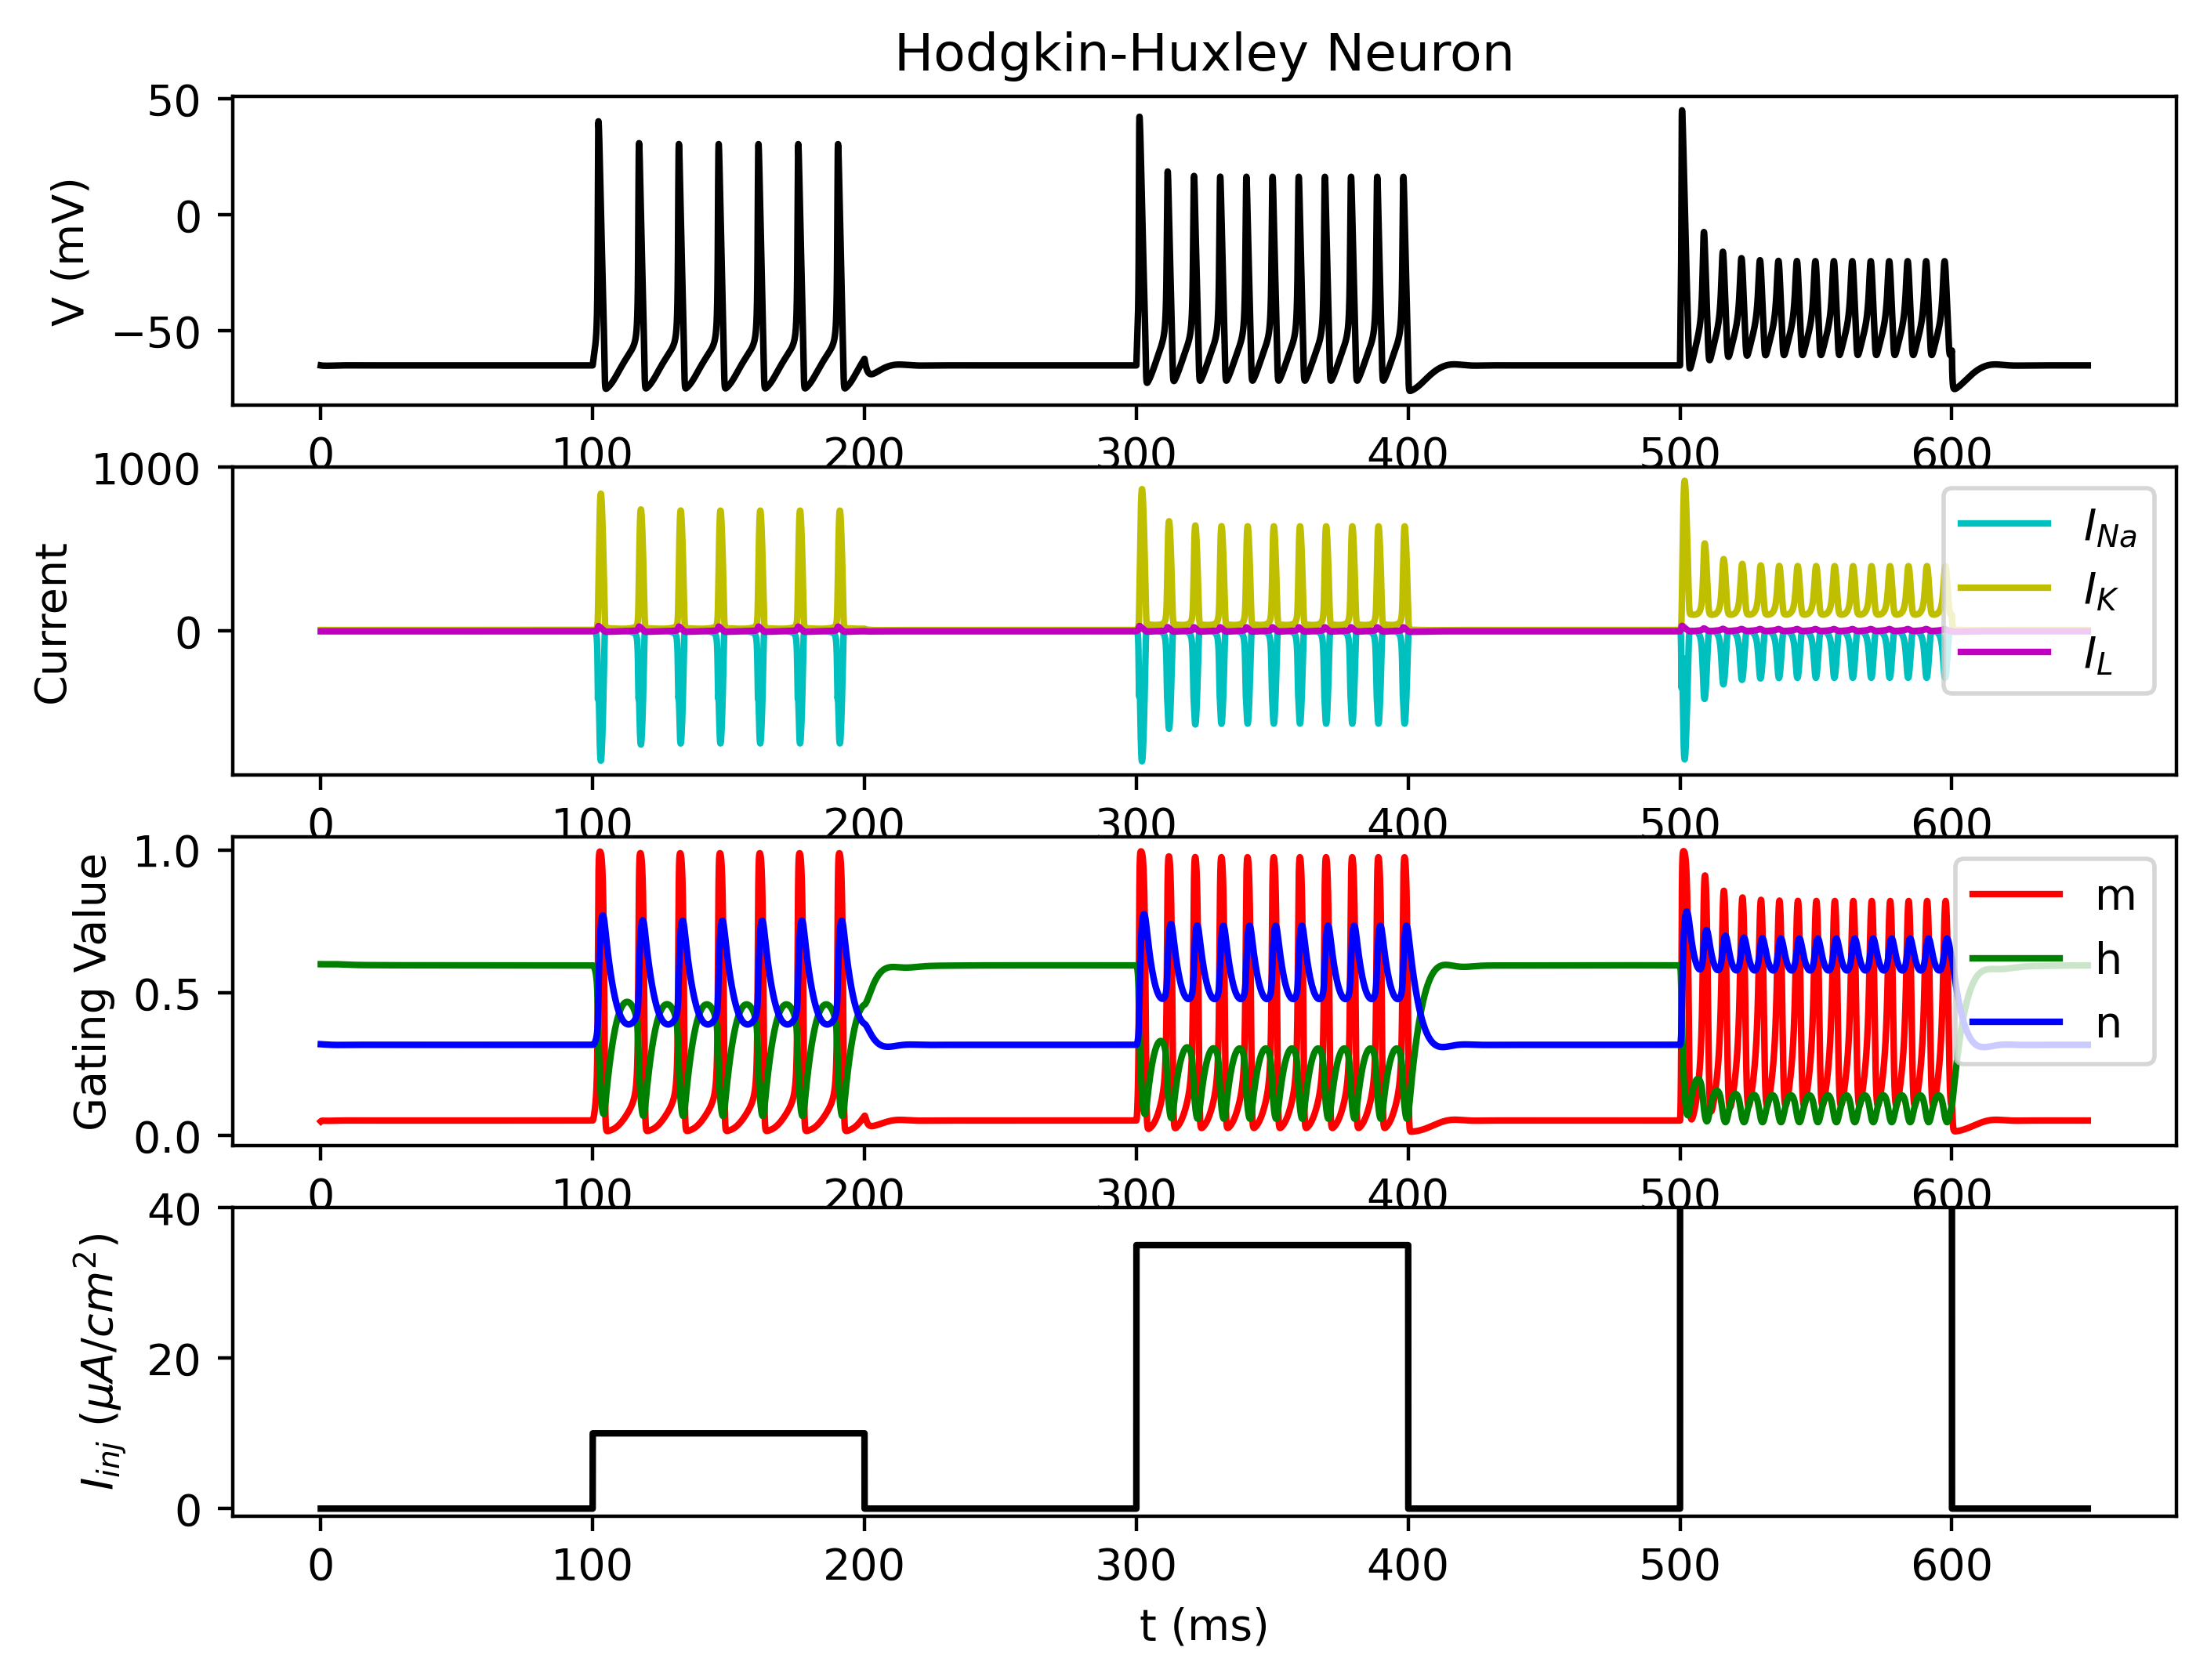

In [2]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint

class HodgkinHuxley():
    """Modelo completo de Hodgkin-Huxley en python"""

    C_m  =   1.0
    """Capacitancia de la membrana, en uF/cm^2"""

    g_Na = 120.0
    """Conductancia máxima del Sodio (Na), en mS/cm^2"""

    g_K  =  36.0
    """Conductancia máxima del Potasio (K), en mS/cm^2"""

    g_L  =   0.3
    """Conductancia máxima del agujero, en mS/cm^2"""

    E_Na =  50.0
    """Potenciales reversos de nest del Sodio (Na), en mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""

    t = sp.arange(0.0, 650.0, 0.01)
    """ The time to integrate over """

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*sp.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*sp.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*sp.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400) + 100*(t>500) - 100*(t>600)

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def Main(self):
        """
        Main demo for the Hodgkin Huxley neuron model
        """

        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure(figsize=(8, 6), dpi=400)

        plt.subplot(4,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V (mV)')

        plt.subplot(4,1,2)
        plt.plot(self.t, ina, 'c', label='$I_{Na}$')
        plt.plot(self.t, ik, 'y', label='$I_{K}$')
        plt.plot(self.t, il, 'm', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend()

        plt.subplot(4,1,3)
        plt.plot(self.t, m, 'r', label='m')
        plt.plot(self.t, h, 'g', label='h')
        plt.plot(self.t, n, 'b', label='n')
        plt.ylabel('Gating Value')
        plt.legend()

        plt.subplot(4,1,4)
        i_inj_values = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj_values, 'k')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)

        plt.show()

if __name__ == '__main__':
    runner = HodgkinHuxley()
    runner.Main()